# 目标检测数据集
**我们收集并标记了一个小型数据集 下载数据集**

In [1]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #解决运行时内核崩溃
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l
import matplotlib.pyplot as plt
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip','5de25c8fce5ccdea9f91267273465dc968d20d72')

**读取香蕉检测数据集**

In [2]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    '''这里得到的data_dir是一个路径对应的字符串'''
    
    csv_fname = os.path.join(data_dir,
                            'bananas_train' if is_train else 'bananas_val',
                            'label.csv')
    print(f"data_dir={data_dir}")
    print(f"csv_fname={csv_fname}")
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    '''
    这里的set_index是把"img_name"这一列的元素作为每一行的索引
    csv_data每一行有五列数据，第一列label值全0，后面四列四个数字描述了一个边缘框
    '''
    images, targets = [], []
    # 把图片、标号全部读到内存里面
    '''
    csv_data.iterrows()返回的可迭对象中的每个元素对应每一行
    img_name是下标，target是那一行剩下的值，这里包括label和边缘框'''
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir,'bananas_train' if is_train else 'bananas_val',
                                                            'images',f'{img_name}')))
        targets.append(list(target))
    print("len(targets)：",len(targets))
    print("len(targets[0])：",len(targets[0]))
    print("targets[0][0]....targets[0][4]：",targets[0][0], targets[0][1], targets[0][2], targets[0][3], targets[0][4])
    print("type(targets)：",type(targets))
    print("torch.tensor(targets).unsqueeze(1).shape：",torch.tensor(targets).unsqueeze(1).shape) # unsqueeze函数在指定位置加上维数为一的维度   
    print("len(torch.tensor(targets).unsqueeze(1) / 256)：", len(torch.tensor(targets).unsqueeze(1) / 256))   
    print("type(torch.tensor(targets).unsqueeze(1) / 256)：", type(torch.tensor(targets).unsqueeze(1) / 256))   
    return images, torch.tensor(targets).unsqueeze(1) / 256 # 归一化使得收敛更快
    '''
    torch.tensor(targets).unsqueeze(1) / 256:
    1.把targets类型转换为了tensor（本来可能是python的列表或NumPy数组）
    2.在维度1上插入了一个长度为1的维度,在这里是把形状从(100,5)变成了(100,1,5)
    3.除以256归一化，使全部值都在0到1之间
    '''

**创建一个自定义`dataset`实例**

In [3]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if is_train else f'validation examples'))   
        
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)

**为训练集和测试集返回两个数据加载器实例**

In [4]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                            batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                          batch_size)
    return train_iter, val_iter

**读取一个小批量，并打印其中的图像和标签的形状**

In [5]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
# ([32,1,5]) 中的1是每张图片中有几种类别，这里只有一种香蕉要识别的类别
# 5是类别标号、框的四个参数
batch[0].shape, batch[1].shape

正在从http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip下载..\data\banana-detection.zip...
data_dir=..\data\banana-detection
csv_fname=..\data\banana-detection\bananas_train\label.csv
len(targets)： 1000
len(targets[0])： 5
targets[0][0]....targets[0][4]： 0 104 20 143 58
type(targets)： <class 'list'>
torch.tensor(targets).unsqueeze(1).shape： torch.Size([1000, 1, 5])
len(torch.tensor(targets).unsqueeze(1) / 256)： 1000
type(torch.tensor(targets).unsqueeze(1) / 256)： <class 'torch.Tensor'>
read 1000 training examples
正在从http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip下载..\data\banana-detection.zip...
data_dir=..\data\banana-detection
csv_fname=..\data\banana-detection\bananas_val\label.csv
len(targets)： 100
len(targets[0])： 5
targets[0][0]....targets[0][4]： 0 183 63 241 112
type(targets)： <class 'list'>
torch.tensor(targets).unsqueeze(1).shape： torch.Size([100, 1, 5])
len(torch.tensor(targets).unsqueeze(1) / 256)： 100
type(torch.tensor(targets).unsqueeze(1) / 256)：

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

**示范**

In [6]:
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
def bbox_to_rect(bbox, color):
    """Defined in :numref:`sec_bbox`"""
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)
    
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框

    Defined in :numref:`sec_anchor`"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(numpy(bbox), color)
        axes.add_patch(rect)
        if labels and len(labels) > i: 
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """
    绘制图像列表
    Defined in :numref:`sec_fashion_mnist`
    """
    print(f"imgs.shape:{imgs.shape}")
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    is_print=False
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if (is_print == False):
            print(f"img.shape:{img.shape}")
            is_print = True
        
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [7]:
imgs = (batch[0][0:10].permute(0,2,3,1)) / 255
axes = show_images(imgs, 2, 5, scale=2)
'''这里的axes是plt.subplots生成的，单个ax显示的具体图片是生成后设置的'''
for ax, label in zip(axes, batch[1][0:10]):
    show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

imgs.shape:torch.Size([10, 256, 256, 3])
img.shape:torch.Size([256, 256, 3])


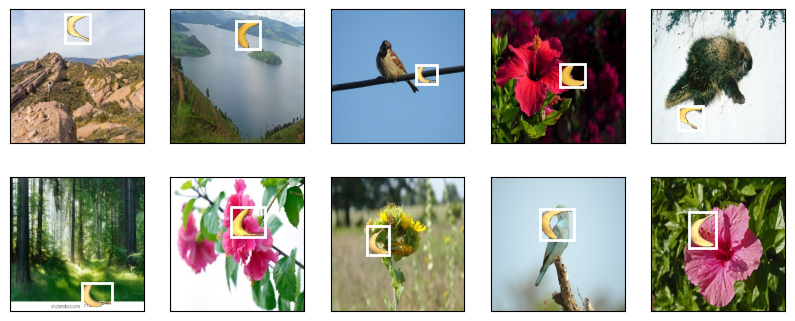

In [8]:
plt.show()